In [1]:
import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics
import seaborn as sns
#import efficientnet.tfkeras as efn
from collections import Counter
from keras_preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from keras.models import  Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D, BatchNormalization, Concatenate
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv1D, Conv2D, MaxPooling2D
from keras.utils import np_utils
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

plt.style.use('ggplot')

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from tensorflow.keras.applications import DenseNet169

In [4]:
densenet169_conv = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in densenet169_conv.layers:
    layer.trainable = True

for layer in densenet169_conv.layers:
    print(layer, layer.trainable)

model = models.Sequential()

model.add(densenet169_conv)

# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(13, activation='softmax'))

51888128/51877672 [==============================] - 0s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f79321a0590> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f7930e84cd0> True
<keras.layers.convolutional.Conv2D object at 0x7f7930e84d50> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f7920328a90> True
<keras.layers.core.activation.Activation object at 0x7f7920388490> True
<keras.layers.convolutional.ZeroPadding2D object at 0x7f79202e1fd0> True
<keras.layers.pooling.MaxPooling2D object at 0x7f79202b9b50> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f79202bfe10> True
<keras.layers.core.activation.Activation object at 0x7f79202cb390> True
<keras.layers.convolutional.Conv2D object at 0x7f794a6f93d0> True
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f79202541d0> True
<keras.layers.core.activation.Activation object at 0x7f792025f150> True
<keras.layers

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 dense (Dense)               (None, 512)               41746944  
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                        

In [6]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001, rho=0.9)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

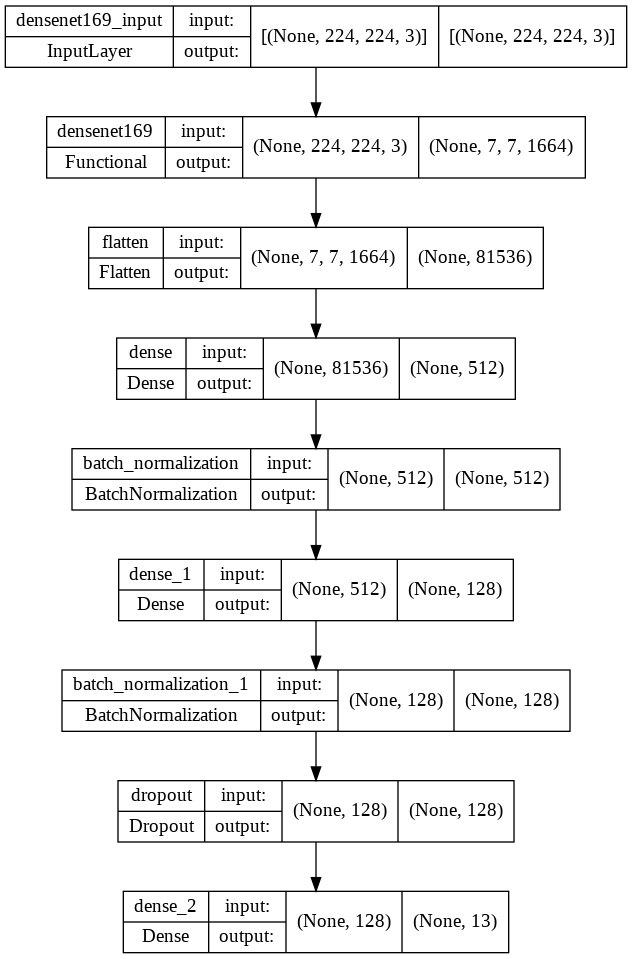

In [7]:
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names = True)
from IPython.display import Image
Image(filename='model.png')

In [8]:
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [10]:
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Birddata_split/New_8_1/train/',
                                                 target_size = (224, 224),
                                                 shuffle=True)

Found 10590 images belonging to 13 classes.


In [11]:
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/Birddata_split/New_8_1/val/',
                                            target_size = (224, 224), shuffle=False)

Found 1303 images belonging to 13 classes.


In [12]:
for cls, idx in training_set.class_indices.items():
    print('Class nr ',idx,' -> ', cls)

Class nr  0  ->  0Capri
Class nr  1  ->  10Pachy
Class nr  2  ->  12Phyll
Class nr  3  ->  14Macro
Class nr  4  ->  1Pnoep
Class nr  5  ->  2Malac
Class nr  6  ->  3Malac
Class nr  7  ->  4Anthi
Class nr  8  ->  5Anthr
Class nr  9  ->  6Corvu
Class nr  10  ->  7Dryoc
Class nr  11  ->  8Elanu
Class nr  12  ->  9Ortho


In [13]:
model_history = model.fit(training_set, batch_size=16, epochs=10, verbose=1, validation_data=(test_set))

Epoch 1/10
331/331 [==============================] - 3823s 11s/step - loss: 0.9517 - accuracy: 0.7329 - val_loss: 0.7561 - val_accuracy: 0.7974
Epoch 2/10
331/331 [==============================] - 153s 462ms/step - loss: 0.4384 - accuracy: 0.8771 - val_loss: 0.4365 - val_accuracy: 0.8649
Epoch 3/10
331/331 [==============================] - 152s 459ms/step - loss: 0.3064 - accuracy: 0.9110 - val_loss: 0.4007 - val_accuracy: 0.8849
Epoch 4/10
331/331 [==============================] - 153s 461ms/step - loss: 0.2202 - accuracy: 0.9384 - val_loss: 0.4354 - val_accuracy: 0.8895
Epoch 5/10
331/331 [==============================] - 152s 460ms/step - loss: 0.1678 - accuracy: 0.9515 - val_loss: 0.4881 - val_accuracy: 0.8787
Epoch 6/10
331/331 [==============================] - 152s 459ms/step - loss: 0.1467 - accuracy: 0.9598 - val_loss: 0.5655 - val_accuracy: 0.8557
Epoch 7/10
331/331 [==============================] - 152s 459ms/step - loss: 0.1197 - accuracy: 0.9664 - val_loss: 0.4950 - 

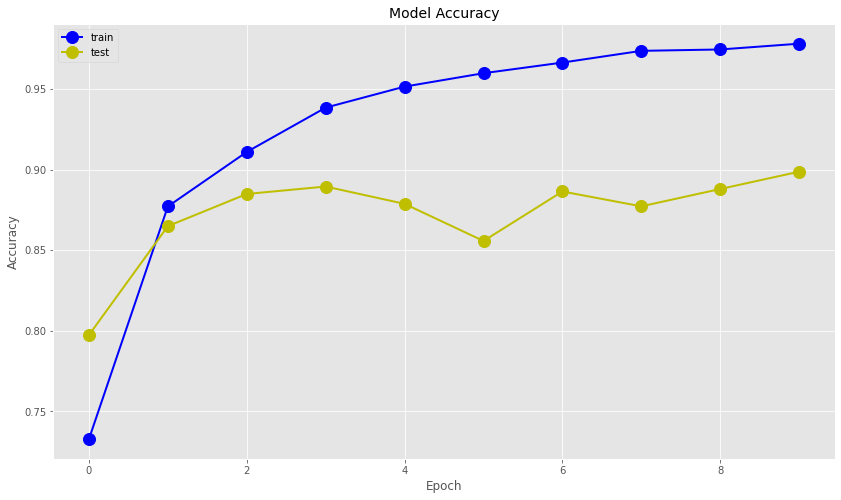

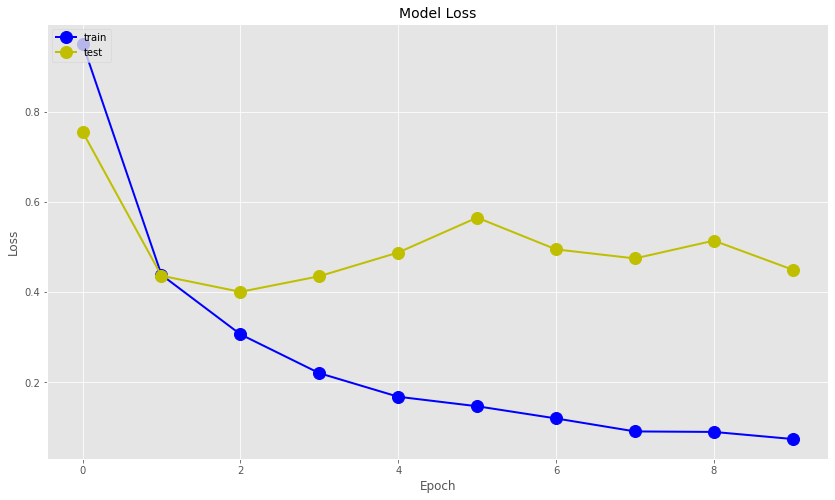

In [14]:
plt.figure(figsize=(14,8))
plt.plot(model_history.history['accuracy'], 'bo-', linewidth=2, markersize=12)
plt.plot(model_history.history['val_accuracy'], 'yo-', linewidth=2, markersize=12)
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 # summarize history for loss
plt.figure(figsize=(14,8))
plt.plot(model_history.history['loss'], 'bo-', linewidth=2, markersize=12 )
plt.plot(model_history.history['val_loss'], 'yo-', linewidth=2, markersize=12)
plt.title('Model Loss', fontsize=14)
plt.ylabel('Loss',fontsize=12)
plt.xlabel('Epoch',fontsize=12)
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
target_names = []
for key in training_set.class_indices:
  target_names.append(key)

print(target_names)

['0Capri', '10Pachy', '12Phyll', '14Macro', '1Pnoep', '2Malac', '3Malac', '4Anthi', '5Anthr', '6Corvu', '7Dryoc', '8Elanu', '9Ortho']


41/41 [==============================] - 7s 158ms/step - loss: 0.4499 - accuracy: 0.8987
n Test_Accuracy:- 0.8986952900886536
confusion matrix
[[ 71   5   0   1   0   0   0   0   3   0   0   0   0]
 [  0  46   0   0   0   4   3   0   0   0   1   0   0]
 [  2   2 268   0   2   1   0   0   2   0   0   0   0]
 [  0   1   1 167   0   0   0   2   6   0   5   0   1]
 [  0   0   3   1 136   6   0   0   0   0   1   0   1]
 [  1   0   0   0   1  59   1   0   0   0   0   0   0]
 [  0   1   8   1   0   2  52   0   1   1   8   0   6]
 [  0   0   3   0   1   0   0  34   0   2   0   0   0]
 [  0   0   3   0   0   0   2   0  43   0   0   0   0]
 [  0   1   0   3   0   0   0   1   6  56   4   0   0]
 [  1   1   1   0   0   0   2   0   3   1  49   0   0]
 [  0   0   0   0   0   1   1   0   2   0   0 134   0]
 [  0   1   5   0   0   2   0   0   0   0   0   0  56]]


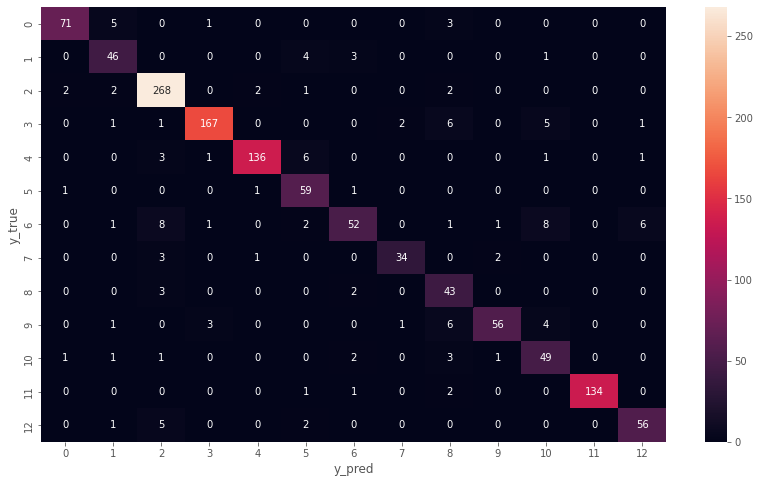

In [16]:
accuracy = model.evaluate(test_set)
print('n', 'Test_Accuracy:-', accuracy[1])
pred = model.predict(test_set)
y_pred = np.argmax(pred, axis=1)
#y_true = np.argmax(pred, axis=1)
print('confusion matrix')
print(confusion_matrix(test_set.classes, y_pred))
    #confusion matrix
f, ax = plt.subplots(figsize=(14,8))
sns.heatmap(confusion_matrix(test_set.classes, y_pred), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_pred")
plt.ylabel("y_true")
plt.show()

In [17]:
print('Classification Report')
print(classification_report(test_set.classes, y_pred, target_names=target_names ))

Classification Report
              precision    recall  f1-score   support

      0Capri       0.95      0.89      0.92        80
     10Pachy       0.79      0.85      0.82        54
     12Phyll       0.92      0.97      0.94       277
     14Macro       0.97      0.91      0.94       183
      1Pnoep       0.97      0.92      0.94       148
      2Malac       0.79      0.95      0.86        62
      3Malac       0.85      0.65      0.74        80
      4Anthi       0.92      0.85      0.88        40
      5Anthr       0.65      0.90      0.75        48
      6Corvu       0.93      0.79      0.85        71
      7Dryoc       0.72      0.84      0.78        58
      8Elanu       1.00      0.97      0.99       138
      9Ortho       0.88      0.88      0.88        64

    accuracy                           0.90      1303
   macro avg       0.87      0.87      0.87      1303
weighted avg       0.91      0.90      0.90      1303



In [18]:
target_names1 = []
for key in test_set.class_indices:
  target_names1.append(key)

print(target_names1)

['0Capri', '10Pachy', '12Phyll', '14Macro', '1Pnoep', '2Malac', '3Malac', '4Anthi', '5Anthr', '6Corvu', '7Dryoc', '8Elanu', '9Ortho']


ROC AUC score: 0.9328599973582559


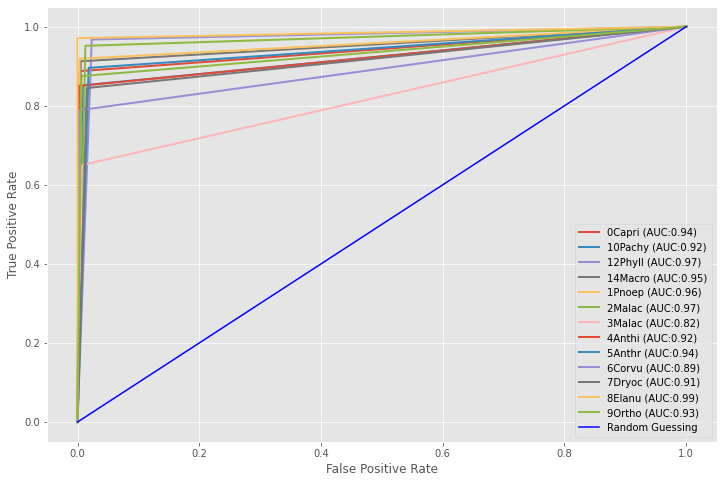

In [19]:
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_preds, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_preds = lb.transform(y_pred)

    for (idx, c_label) in enumerate(target_names1):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_preds[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)),linewidth=2)
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_preds, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(test_set.classes, pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [20]:
top_k_accuracy_score(test_set.classes, pred, k=5)

0.9662317728319263

In [21]:
top_k_accuracy_score(test_set.classes, pred, k=5, normalize=False)

1259

In [22]:
top_k_accuracy_score(test_set.classes, pred, k=1)

0.898695318495779

In [23]:
top_k_accuracy_score(test_set.classes, pred, k=1, normalize=False)

1171

In [24]:
model.save('/content/drive/MyDrive/Birddata_split/m2_rmsprop_3.hdf5')

In [25]:
finalpreds = pd.DataFrame(y_pred)
#finalpreds.columns = sub_temp.columns
finalpreds.to_csv('/content/drive/MyDrive/Birddata_split/M2_rmsprop_3.csv',index=False)